In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# lib data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#lib visual
import matplotlib.pyplot as plt
import seaborn as sns
#QQ Plot
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype

#lib file
from pathlib import Path

#data prepare lib
from pandas.api.types import CategoricalDtype

#lib model
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import plot_importance
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

#lib metric and validation 
from sklearn.model_selection import KFold, cross_val_score

#lib check skewness , kurtosis
from scipy.stats import skew,kurtosis

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [42]:
# read file
PATH_DIR  = "/kaggle/input/house-prices-advanced-regression-techniques/"
PATH_FILE_TRAIN = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
PATH_FILE_TEST = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"

df_data = pd.read_csv(PATH_FILE_TRAIN)

In [43]:
df_test = pd.read_csv(PATH_FILE_TEST)
df_test.shape

(1459, 80)

In [44]:
# display column and data type
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [45]:
#check duplicate
foud_dup_recourds = len(df_data[df_data.duplicated()])
if(foud_dup_recourds==0):
    print("Not found duplicated rows")
else:
     print("found duplicated {} rows".format(foud_dup_recourds))

Not found duplicated rows


In [46]:
#check missing value

#function display missing value percent
def display_percent_missing(df):    
    percent_missing =  df.isna().sum()/df.shape[0]*100
    df_percent = percent_missing.to_frame()
    df_percent.reset_index(inplace=True)
    df_percent = df_percent.rename(columns = {'index':'Feature'})
    df_percent = df_percent.rename(columns = {0:'Percent'})
    df_percent.sort_values(by='Percent', ascending=False , inplace=True)
    
    for i in range(df_percent.shape[0]):
        print(df_percent.iloc[i, 0], df_percent.iloc[i, 1])

In [47]:
display_percent_missing(df_data)

PoolQC 99.52054794520548
MiscFeature 96.30136986301369
Alley 93.76712328767123
Fence 80.75342465753424
FireplaceQu 47.26027397260274
LotFrontage 17.73972602739726
GarageYrBlt 5.5479452054794525
GarageCond 5.5479452054794525
GarageType 5.5479452054794525
GarageFinish 5.5479452054794525
GarageQual 5.5479452054794525
BsmtFinType2 2.6027397260273974
BsmtExposure 2.6027397260273974
BsmtQual 2.5342465753424657
BsmtCond 2.5342465753424657
BsmtFinType1 2.5342465753424657
MasVnrArea 0.547945205479452
MasVnrType 0.547945205479452
Electrical 0.0684931506849315
Id 0.0
Functional 0.0
Fireplaces 0.0
KitchenQual 0.0
KitchenAbvGr 0.0
BedroomAbvGr 0.0
HalfBath 0.0
FullBath 0.0
BsmtHalfBath 0.0
TotRmsAbvGrd 0.0
GarageCars 0.0
GrLivArea 0.0
GarageArea 0.0
PavedDrive 0.0
WoodDeckSF 0.0
OpenPorchSF 0.0
EnclosedPorch 0.0
3SsnPorch 0.0
ScreenPorch 0.0
PoolArea 0.0
MiscVal 0.0
MoSold 0.0
YrSold 0.0
SaleType 0.0
SaleCondition 0.0
BsmtFullBath 0.0
HeatingQC 0.0
LowQualFinSF 0.0
LandSlope 0.0
OverallQual 0.0
Hou

In [48]:
# PoolQC: Pool quality
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        NA	No Pool

#MiscFeature
# MiscFeature: Miscellaneous feature not covered in other categories
		
#        Elev	Elevator
#        Gar2	2nd Garage (if not described in garage section)
#        Othr	Other
#        Shed	Shed (over 100 SF)
#        TenC	Tennis Court
#        NA	None

# Alley: Type of alley access to property
#        Grvl	Gravel
#        Pave	Paved
#        NA 	No alley access

#PoolQC MiscFeature Alley  mi

In [49]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
        }, inplace=True,
    )
    
    #drop id column
    #df.drop(['Id'],axis=1,inplace=True)
    
    return df


# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

# def load_data(path_dir):
#     # Read data
#     data_dir = Path(path_dir)
#     df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
#     df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    
#     # Merge the splits so we can process them together
#     df = pd.concat([df_train, df_test])
#     # Preprocessing
#     df = clean(df)
#     df = encode(df)
#     df = impute(df)
   
#     # Reform splits
#     df_train = df.loc[df_train.index, :]
#     df_test = df.loc[df_test.index, :]
#     return df_train, df_test


def load_data():
    # Read data
    data_dir = Path(PATH_DIR)
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
   
    df = clean(df)
    df = encode(df)
    df = impute(df)

    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


def preprocess_data():
    # Preprocessing
#     df = clean(df)
#     df = encode(df)
#     df = impute(df)
    #print("in preprocess")
    pass

def load_data_for_eda():
    # Read data
    data_dir = Path(PATH_DIR)
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
   
    df = clean(df)
    df = encode(df)
    df = impute(df)

    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [50]:
df_eda_train , df_eda_test = load_data_for_eda()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [51]:
def plot_graph_numeric(data,name):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle('Distribution Feature {}'.format(name))
    
    sns.boxplot(ax=axes[0], y=data[name])
    axes[0].set_title("Box plot")
    
    sns.histplot(ax=axes[1], x=data[name],kde=True)
    axes[1].set_title("Normal curve")
  
    sm.qqplot( data=data[name], line='s', ax=axes[2])
    

In [52]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )


In [53]:
corr = df_eda_train.corr()
# plt.figure(figsize=(15, 15))
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

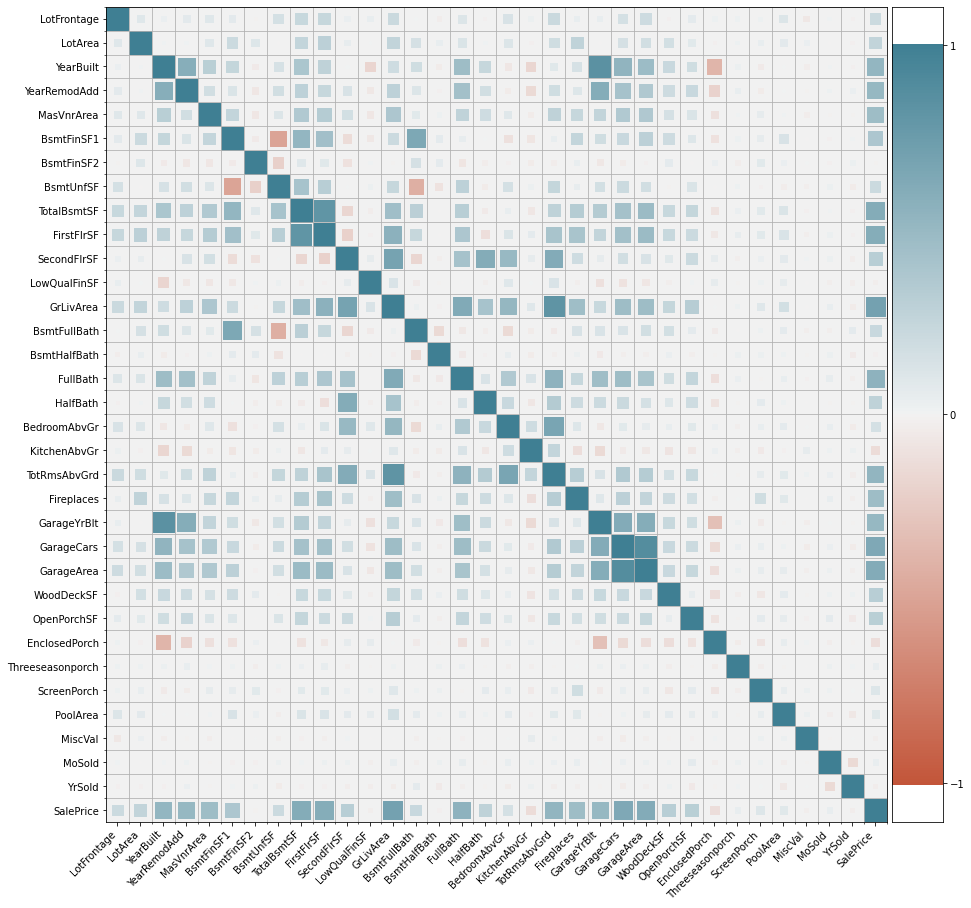

In [54]:
plt.figure(figsize=(15, 15))
corrplot(corr)

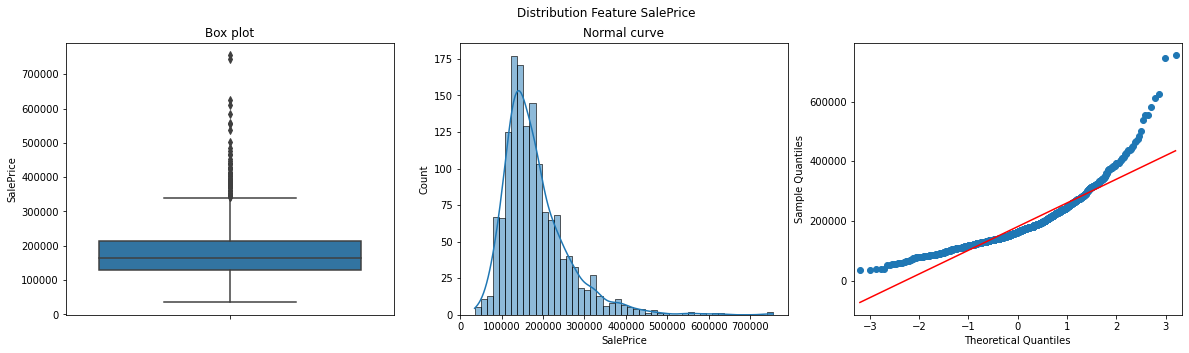

In [56]:
# eda sale price
plot_graph_numeric(df_eda_train,'SalePrice')

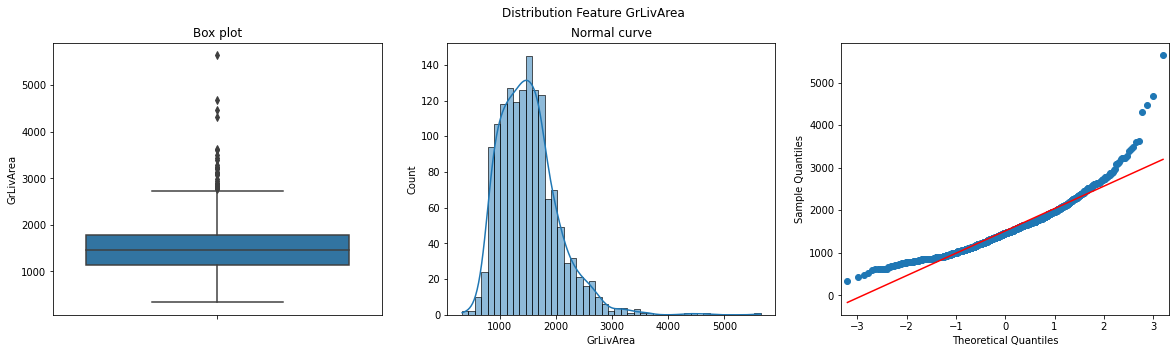

In [57]:

plot_graph_numeric(df_eda_train,'GrLivArea')


*# Found outlier and right skewness*

In [58]:
df_train, df_test = load_data()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [59]:
#EDA DATA

In [60]:
# def score_dataset(X, y, model=XGBRegressor()):
#     # Label encoding for categoricals
#     #
#     # Label encoding is good for XGBoost and RandomForest, but one-hot
#     # would be better for models like Lasso or Ridge. The `cat.codes`
#     # attribute holds the category levels.
#     for colname in X.select_dtypes(["category"]):
#         X[colname] = X[colname].cat.codes
#     # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
#     log_y = np.log(y)
#     score = cross_val_score(
#         model, X, log_y, cv=5, scoring="neg_mean_squared_error",
#     )
#     score = -1 * score.mean()
#     score = np.sqrt(score)
#     return score , X , y 

In [61]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
def score_dataset(X, y, pipeline):
    #print(X.PoolQC.unique())
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)

    
    log_y = np.log(y)
#     cv_score = cross_val_score(
#         pipeline, X, log_y, cv=5, scoring="neg_mean_squared_error",
#     )
#     score = -1 * cv_score.mean()
#     score = np.sqrt(score)

   
    cv_score = cross_val_score(
        pipeline, X, log_y, cv=kf, scoring="neg_mean_squared_error",
    )
    return cv_score , X , y 

def cal_rmsle_score(cv_score_list):
    cv_rmsle_score = -1 * cv_score_list
    cv_rmsle_score = np.sqrt(cv_rmsle_score)
    return cv_rmsle_score


In [62]:
X = df_train.copy()
y = X.pop("SalePrice")

In [63]:
# baseline_score = score_dataset(X, y)
# print(f"Baseline score: {baseline_score:.5f} RMSLE")

In [64]:
def get_model_score(model,X_train,y_train):
    my_pipeline = Pipeline(steps=[
                                    ('preprocessor', preprocess_data()),
                                    ('model', model)
                                 ])
    baseline_score , X_train , y_train = score_dataset(X_train,y_train,my_pipeline)
    rmsle_score = cal_rmsle_score(baseline_score)
    
    #print(baseline_score)
    #print(rmsle_score)
    
    print(f"score: {rmsle_score.mean():.5f} RMSLE")
    return rmsle_score

In [65]:
#model selection
xgb_model = XGBRegressor()
rf_model = RandomForestRegressor()
lr_model = LinearRegression()
model_selection_dict = {
                        "xgb":xgb_model
                        ,"rf":rf_model
                        ,"lr":lr_model
                       }

score: 0.14406 RMSLE
score: 0.14080 RMSLE
score: 0.16261 RMSLE


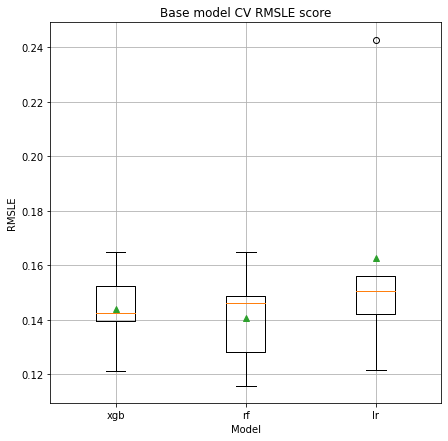

In [66]:
#Base model score
model_name_list = list(model_selection_dict.keys())
model_score_list = list()

for model_name in model_name_list:
    model = model_selection_dict[model_name]
    cv_score = get_model_score(model,X,y)
    model_score_list.append(cv_score)
    
#visualize base model score
plt.figure(figsize=(7,7))
plt.boxplot(model_score_list,labels=model_name_list,showmeans=True)
plt.title("Base model CV RMSLE score")
plt.xlabel('Model')
plt.ylabel('RMSLE')
plt.grid()
plt.show()

In [67]:
#select random forest 

In [167]:
# start feature selection 
# find mutual information from feature
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# visualize  mutual information from feature
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(20, 20))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

def make_corr_scores(df):
    df_corr_sale = df_eda_train.corr()['SalePrice'] #array of correlation values for each variable vs. SalePrice 
    return df_corr_sale

def drop_uncorrelation(df,df_corr_sale):
    df_corr_threshold = df_corr_sale[np.abs(df_corr_sale)>0.5].reset_index()
    df_corr_threshold = df_corr_threshold.rename(columns = {'index':'Feature'})
    column_num_list = df_corr_threshold.Feature.to_list()
    column_num_list.remove('SalePrice')
    df.drop(column_num_list,axis=1,inplace=True)
    return df

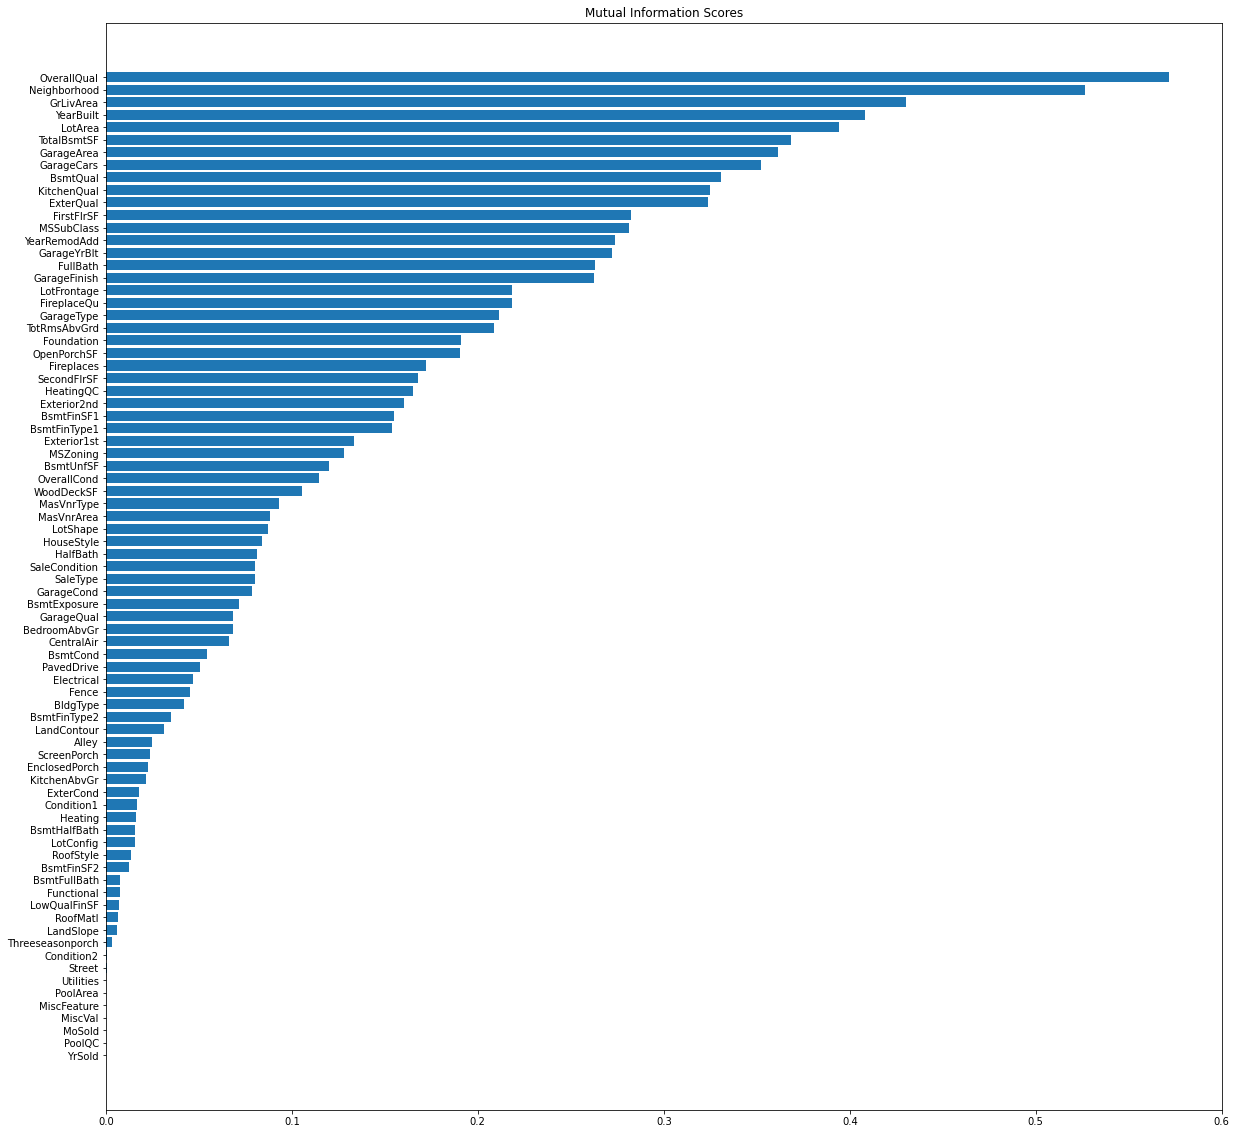

In [142]:
mi_scores = make_mi_scores(X,y)
plot_mi_scores(mi_scores)

In [143]:
print(mi_scores)

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64


In [157]:
CORR_THRESHOLD = 0.5
df_corr_sale = make_corr_scores(df_eda_train)
df_corr_threshold = df_corr_sale[np.abs(df_corr_sale)>CORR_THRESHOLD].reset_index()

df_corr_threshold = df_corr_threshold.rename(columns = {'index':'Feature'})
#df_corr_threshold.head()

column_num_list = df_corr_threshold.Feature.to_list()



print(column_num_list)

# #df_corr_threshold = df_corr_sale[np.abs]

['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'FirstFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea']


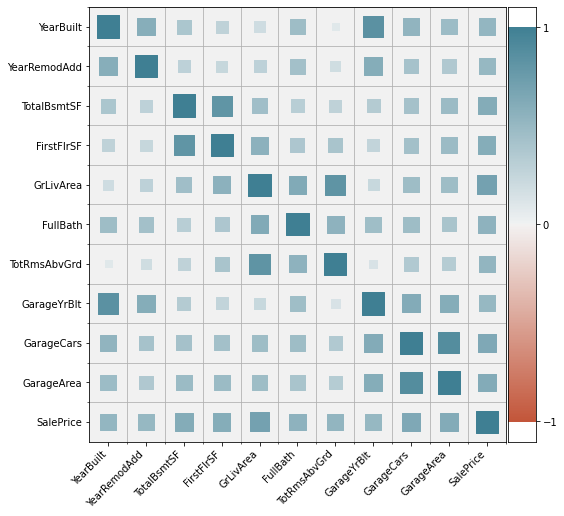

In [145]:
# plot heat map corr >0.5
df_plot_corr = df_eda_train[column_num_list]

plt.figure(figsize=(8, 8))
corrplot(df_plot_corr.corr())

In [174]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)
    corr_scores = make_corr_scores(X)
    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    #Mutual Information
    #droup feature mi uninformative
    X = drop_uninformative(X, mi_scores)
    #X = drop_uncorrelation(X,corr_scores)
   
    # Reform splits
    
    print(type(X))
    
    
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    

    if df_test is not None:
        return X, X_test
    else:
        return X




In [175]:
df_train, df_test = load_data()

X_train , X_test  = create_features(df_train,df_test)
y_train  = df_train.loc[:, "SalePrice"]



/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


<class 'pandas.core.frame.DataFrame'>


In [176]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 74 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

score: 0.14303 RMSLE
score: 0.14093 RMSLE
score: 0.16115 RMSLE


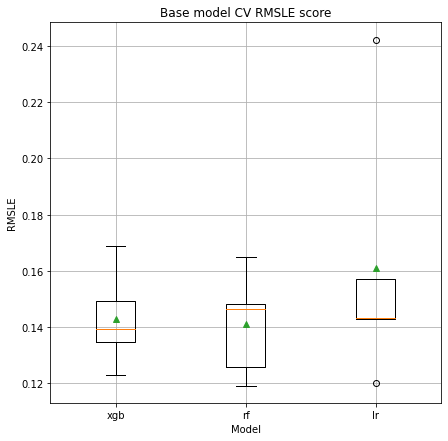

In [177]:
model_score_list = list()
for model_name in model_name_list:
    model = model_selection_dict[model_name]
    cv_score = get_model_score(model,X_train,y_train)
    model_score_list.append(cv_score)
    
#visualize base model score
plt.figure(figsize=(7,7))
plt.boxplot(model_score_list,labels=model_name_list,showmeans=True)
plt.title("Base model CV RMSLE score")
plt.xlabel('Model')
plt.ylabel('RMSLE')
plt.grid()
plt.show()

In [ ]:
def encode_cat(df):
    for colname in df.select_dtypes(["category"]):
        #print(colname)
        df[colname] = df[colname].cat.codes
    return df

In [ ]:
#choose RandomForestRegressor model have minimum RMSLE
#prepare summission

df_train, df_test = load_data()
X_train , X_test  = create_features(df_train,df_test)
y_train  = df_train.loc[:, "SalePrice"]

X_train = encode_cat(X_train)
X_test = encode_cat(X_test)

X_train.head()

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train,np.log(y_train))

predictions = np.exp(rf.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission_1.csv', index=False)
print("Your submission was successfully saved!")
